In [1]:
import numpy as np
import matplotlib.pyplot as plt  # To visualize
import pandas as pd  # To read data

import math
import torch
import tqdm
import gpytorch
from matplotlib import pyplot as plt

%matplotlib inline
%load_ext autoreload
%autoreload 2

from gpytorch.models import ExactGP
from gpytorch.kernels import ScaleKernel, RBFKernel, PeriodicKernel
from gpytorch.means import ConstantMean

data_dir = '../../../data/'

### Load the data

In [16]:
# Read the data and parse the PROF_DATE_TIME_LOCAL column to a datetime object
data = pd.read_csv(data_dir + 'concat/MWRA_TA_DIC_2017_to_2022.csv'
                   , parse_dates=['PROF_DATE_TIME_LOCAL'])

# convert the data column to a value that can be used for machine learning
data['PROF_DATE_TIME_LOCAL'] = pd.to_datetime(data['PROF_DATE_TIME_LOCAL'], utc=True)
data['YEAR'] = data['PROF_DATE_TIME_LOCAL'].dt.year
data['MONTH'] = data['PROF_DATE_TIME_LOCAL'].dt.month
data['DAY'] = data['PROF_DATE_TIME_LOCAL'].dt.day

sal_temp_ph = data[
  (data['SAL (PSU)'].notnull())
  & (data['pH ()'].notnull())
  & (data['TEMP (C)'].notnull())
  & (data['PROF_DATE_TIME_LOCAL'].notnull())
  & (data['DEPTH (m)'].notnull())
  & (data['LATITUDE'].notnull())
  & (data['LONGITUDE'].notnull())
  & (data['VAL_QUAL'] != -1)
  ]

# Station N18 will be used for validation
station = 'N18'
n18 = sal_temp_ph[sal_temp_ph['STAT_ID'] == station]
f22 = sal_temp_ph[sal_temp_ph['STAT_ID'] == 'F22']
f22.drop_duplicates(subset=['YEAR', 'MONTH', 'DAY'], keep='first', inplace=True)
n18.drop_duplicates(subset=['YEAR', 'MONTH', 'DAY'], keep='first', inplace=True)

sal_temp_ph = sal_temp_ph[sal_temp_ph['STAT_ID'] != station]

len(sal_temp_ph)

print(sal_temp_ph[['SAL (PSU)', 'TEMP (C)', 'YEAR', 'MONTH', 'DAY', 'LATITUDE', 'LONGITUDE', 'DEPTH (m)']].values.shape)

(2669, 8)


/var/folders/48/8wmkrk0n7zv6l_5n7nb7g9dr0000gn/T/ipykernel_4119/890109294.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f22.drop_duplicates(subset=['YEAR', 'MONTH', 'DAY'], keep='first', inplace=True)
/var/folders/48/8wmkrk0n7zv6l_5n7nb7g9dr0000gn/T/ipykernel_4119/890109294.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  n18.drop_duplicates(subset=['YEAR', 'MONTH', 'DAY'], keep='first', inplace=True)


### Gaussian Process Regression

In [17]:
SAL = sal_temp_ph['SAL (PSU)'].values.reshape(-1, 1)
TEMP = sal_temp_ph['TEMP (C)'].values.reshape(-1, 1)
YEAR = sal_temp_ph['YEAR'].values.reshape(-1, 1)
MONTH = sal_temp_ph['MONTH'].values.reshape(-1, 1)
DAY = sal_temp_ph['DAY'].values.reshape(-1, 1)
LAT = sal_temp_ph['LATITUDE'].values.reshape(-1, 1)
LON = sal_temp_ph['LONGITUDE'].values.reshape(-1, 1)
DEPTH = sal_temp_ph['DEPTH (m)'].values.reshape(-1, 1)

X = np.concatenate((SAL, TEMP, YEAR, MONTH, DAY, LAT, LON, DEPTH), axis=1)
#X = np.concatenate((LAT, LON), axis=1)

Y = sal_temp_ph['pH ()'].values

In [18]:
train_x = torch.from_numpy(X).float()
train_y = torch.from_numpy(Y).float()

print(train_x.shape)
print(train_y.shape)

torch.Size([2669, 8])
torch.Size([2669])


In [4]:
# We will use the simplest form of GP model, exact inference
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = ScaleKernel(PeriodicKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# We will use the simplest form of GP model, exact inference
class ExactGPModelR(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = ScaleKernel(RBFKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

In [9]:
# initialize likelihood and model
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = ExactGPModel(train_x, train_y, likelihood)

In [39]:
# If a gpu is available, use it
print(torch.cuda.is_available())
if torch.cuda.is_available():
    model = model.cuda()
    likelihood = likelihood.cuda()
    train_x = train_x.cuda()
    train_y = train_y.cuda()

False


In [40]:
# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.05)  # Includes GaussianLikelihood parameters

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

In [42]:
training_iter = 300

for i in range(training_iter):
    # Zero gradients from previous iteration
    optimizer.zero_grad()
    # Output from model
    output = model(train_x)
    # Calc loss and backprop gradients
    loss = -mll(output, train_y)
    loss.sum().backward()
    print('Iter %d/%d - Loss: %.3f   lengthscale: %.3f   noise: %.3f' % (
        i + 1, training_iter, loss.item(),
        model.covar_module.base_kernel.lengthscale.item(),
        model.likelihood.noise.item()
    ))
    optimizer.step()

Iter 1/5 - Loss: 1.288   lengthscale: 1.595   noise: 1.320
Iter 2/5 - Loss: 1.431   lengthscale: 1.745   noise: 1.355
Iter 3/5 - Loss: 1.375   lengthscale: 1.882   noise: 1.368
Iter 4/5 - Loss: 1.296   lengthscale: 2.007   noise: 1.363
Iter 5/5 - Loss: 1.395   lengthscale: 2.121   noise: 1.339


In [19]:
# Load trained model from memory
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = ExactGPModel(train_x, train_y, likelihood)
model.load_state_dict(torch.load('../models/pH_0.105Loss.pt', map_location=torch.device('cpu')))

<All keys matched successfully>

In [20]:
model.cpu()
likelihood.cpu()

model.eval()
likelihood.eval()

years = {}
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    for name, df in n18.groupby('YEAR'):
        test_x = torch.from_numpy(df[['SAL (PSU)', 'TEMP (C)', 'YEAR', 'MONTH', 'DAY', 'LATITUDE', 'LONGITUDE', 'DEPTH (m)']].values).float()
        observed_pred = likelihood(model(test_x))
        mean = observed_pred.mean
        lower, upper = observed_pred.confidence_region()
        years[name] = pd.DataFrame({'mean': mean, 'lower': lower, 'upper': upper})
train_x = train_x.cpu()
train_y = train_y.cpu()

/var/folders/48/8wmkrk0n7zv6l_5n7nb7g9dr0000gn/T/ipykernel_4119/582039082.py:22: FutureWarning: Using .astype to convert from timezone-aware dtype to timezone-naive dtype is deprecated and will raise in a future version.  Use obj.tz_localize(None) or obj.tz_convert('UTC').tz_localize(None) instead
  dates2 = dates.astype('datetime64[ns]')


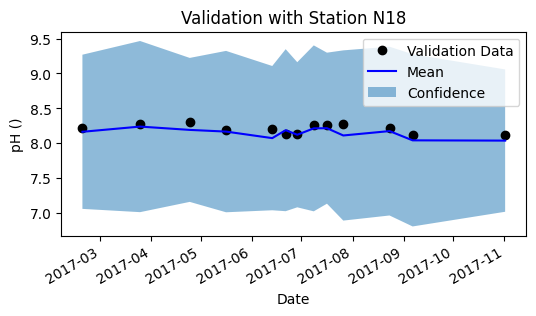

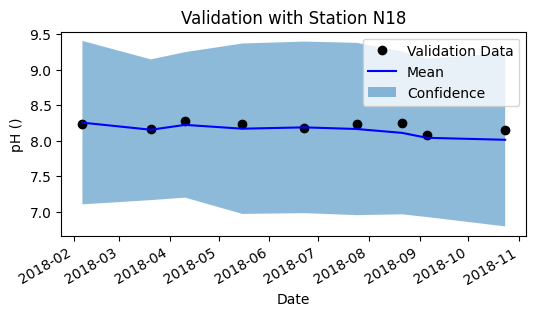

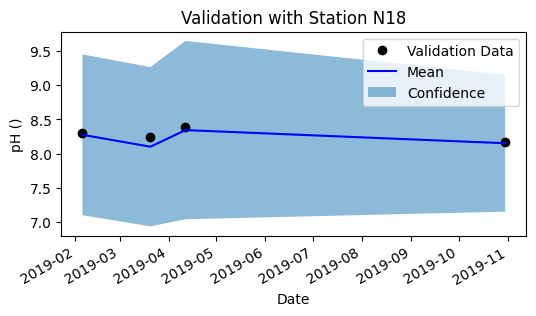

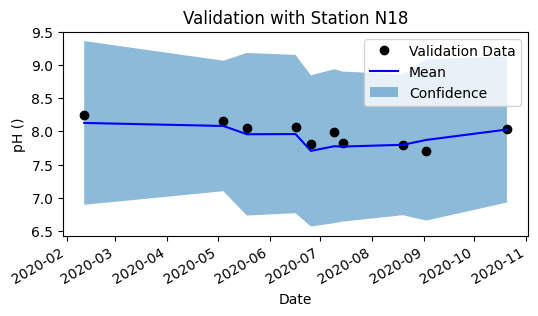

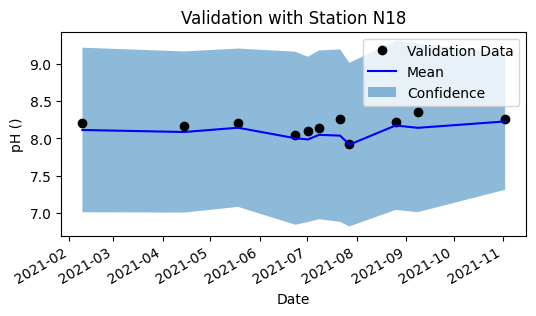

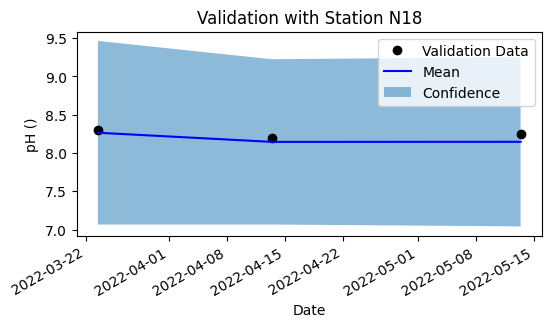

In [21]:
#dates = n18['PROF_DATE_TIME_LOCAL']
with torch.no_grad():
    for year in years:
        eval = years[year]
        df = n18[n18['YEAR'] == year]
        dates = df['PROF_DATE_TIME_LOCAL']
        mean = eval['mean']
        lower = eval['lower']
        upper = eval['upper']
        # Initialize plot
        f, ax = plt.subplots(1, 1, figsize=(6, 3))

        # Plot training data as black stars
        ax.plot(df['PROF_DATE_TIME_LOCAL'], df['pH ()'], 'ko')

        # Max date
        max_date = dates.max()
        min_date = dates.min()

        # Date for every day in the range
        #dates2 = np.arange(min_date, max_date, dtype='datetime64[D]')
        dates2 = dates.astype('datetime64[ns]')
        
        # Plot predictive means as blue line
        ax.plot(dates, mean.to_numpy(), 'b')

        # Shade between the lower and upper confidence bounds
        ax.fill_between(dates, lower.to_numpy(), upper.to_numpy(), alpha=0.5)

        plt.gcf().autofmt_xdate()
        
        # Set x axis label
        ax.set_xlabel('Date')

        # Set y axis label
        ax.set_ylabel('pH ()')

        ax.legend(['Validation Data', 'Mean', 'Confidence'])

        # Title
        ax.set_title('Validation with Station N18')

In [5]:
data = pd.read_csv(data_dir + 'concat/MWRA_TA_DIC_2017_to_2022.csv'
                   , parse_dates=['PROF_DATE_TIME_LOCAL'])


sal_temp_ph = data[
  (data['SAL (PSU)'].notnull())
  & (data['pH ()'].notnull())
  & (data['TEMP (C)'].notnull())
  & (data['VAL_QUAL'] != -1)
  ]

# Remove HAR station

# 20 percent of data will be used for validation
# 80 percent of data will be used for training
#validation = sal_temp_ph.sample(frac=0.2, random_state=1)

#sal_temp_ph = sal_temp_ph.drop(validation.index)

station = 'N18'
validation = sal_temp_ph[sal_temp_ph['STAT_ID'] == station]
sal_temp_ph = sal_temp_ph[sal_temp_ph['STAT_ID'] != station]

SAL = sal_temp_ph['SAL (PSU)'].values.reshape(-1, 1)
TEMP = sal_temp_ph['TEMP (C)'].values.reshape(-1, 1)

X = np.concatenate((SAL, TEMP), axis=1)
Y = sal_temp_ph['pH ()'].values

train_x_n = torch.from_numpy(X).float()
train_y_n = torch.from_numpy(Y).float()

likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = ExactGPModelR(train_x_n, train_y_n, likelihood)
model.load_state_dict(torch.load('../models/pH_0.-0.589Loss.pt', map_location=torch.device('cpu')))


TypeError: super(type, obj): obj must be an instance or subtype of type

In [26]:
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    test_x = torch.from_numpy(n18[['SAL (PSU)', 'TEMP (C)', 'YEAR', 'MONTH', 'DAY', 'LATITUDE', 'LONGITUDE', 'DEPTH (m)']].values).float()
    observed_pred = likelihood(model(test_x))
    mean = observed_pred.mean
    lower, upper = observed_pred.confidence_region()
    
train_x = train_x.cpu()
train_y = train_y.cpu()

/var/folders/48/8wmkrk0n7zv6l_5n7nb7g9dr0000gn/T/ipykernel_4119/1648115347.py:16: FutureWarning: Using .astype to convert from timezone-aware dtype to timezone-naive dtype is deprecated and will raise in a future version.  Use obj.tz_localize(None) or obj.tz_convert('UTC').tz_localize(None) instead
  dates2 = dates.astype('datetime64[ns]')


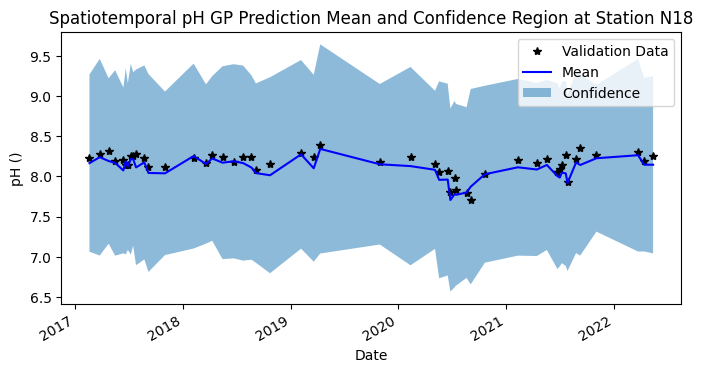

In [28]:
#dates = n18['PROF_DATE_TIME_LOCAL']
with torch.no_grad():
    dates = n18['PROF_DATE_TIME_LOCAL']
    # Initialize plot
    f, ax = plt.subplots(1, 1, figsize=(8, 4))

    # Plot training data as black stars
    ax.plot(n18['PROF_DATE_TIME_LOCAL'], n18['pH ()'], 'k*')

    # Max date
    max_date = dates.max()
    min_date = dates.min()

    # Date for every day in the range
    #dates2 = np.arange(min_date, max_date, dtype='datetime64[D]')
    dates2 = dates.astype('datetime64[ns]')
    
    # Plot predictive means as blue line
    ax.plot(dates, mean.numpy(), 'b')

    # Shade between the lower and upper confidence bounds
    ax.fill_between(dates, lower.numpy(), upper.numpy(), alpha=0.5)

    plt.gcf().autofmt_xdate()
    
    # Set x axis label
    ax.set_xlabel('Date')

    # Set y axis label
    ax.set_ylabel('pH ()')

    ax.legend(['Validation Data', 'Mean', 'Confidence'])

    # Title
    ax.set_title('Spatiotemporal pH GP Prediction Mean and Confidence Region at Station N18')

In [ ]:
n18_test = pd.DataFrame()
x = np.arange(0, len(n18))
for column in ['SAL (PSU)', 'TEMP (C)', 'LATITUDE', 'LONGITUDE', 'DEPTH (m)']:
    y = n18[column].values
    xvals = np.linspace(0, len(n18), 1000)
    test_x = np.interp(xvals, x, y)

SAL, TEMP, YEAR, MONTH, DAY, LAT, LON, DEPTH
y = n18[['SAL (PSU)', 'TEMP (C)', 'YEAR', 'MONTH', 'DAY', 'LATITUDE', 'LONGITUDE', 'DEPTH (m)']].values
xvals = np.linspace(0, len(n18), 500)
test_x = np.interp(xvals, x, y)

In [ ]:
# Load trained model from memory
model = ExactGPModel(train_x, train_y, likelihood)
model.load_state_dict(torch.load('pH_0.165Loss.pt', map_location=torch.device('cpu')))